# Do not run the following code since all process is completed

## Download Data 
Download data from https://zenodo.org/record/1327317#.Y1Fs1uzMI1I
<br>Do not upload them to github, the gitignore file will ignore all .zip files.

<br>Run the following cells to unzip the files.
<br>Do not upload images to github, the gitignore file will ignore all .png files.

In [ ]:
return x
!unzip training_set.zip

In [ ]:
!unzip test_set.zip

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

## Masking

### Warning!!!
Run the following cell ONLY once. If you have ran this part before, even if the jupyter notebook lost connection, do not run it again. The images you downloaded have been modified with the masks.

In [ ]:
train_pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' 
# we will get annotation names

<table align="left"><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="training_set/000_HC.png" width="320">
    <br>
    <em style="color: grey">Original Image 000_HC.png</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="training_set/000_HC_Annotation.png" width="320">
    <br>
    <em style="color: grey">Annotation of Image 000_HC_Annotation.png</em>
  </p> 
</td>
</tr></table>

In [ ]:
# This function takes the annotation of image and spits out corresponding mask
def masking(image):
    # Convert image to grayscale
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Convert image to black and white, visit https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
    # cv2.THRESH_BINARY = 0
    ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)

    # Draw the edge of the white shape, visit https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html
    # cv2.RETR_TREE = 3; cv2.CHAIN_APPROX_SIMPLE = 2
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Fit the edge to ellipse, visit https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

### This is something your will get running the following code
<br>
<div>
    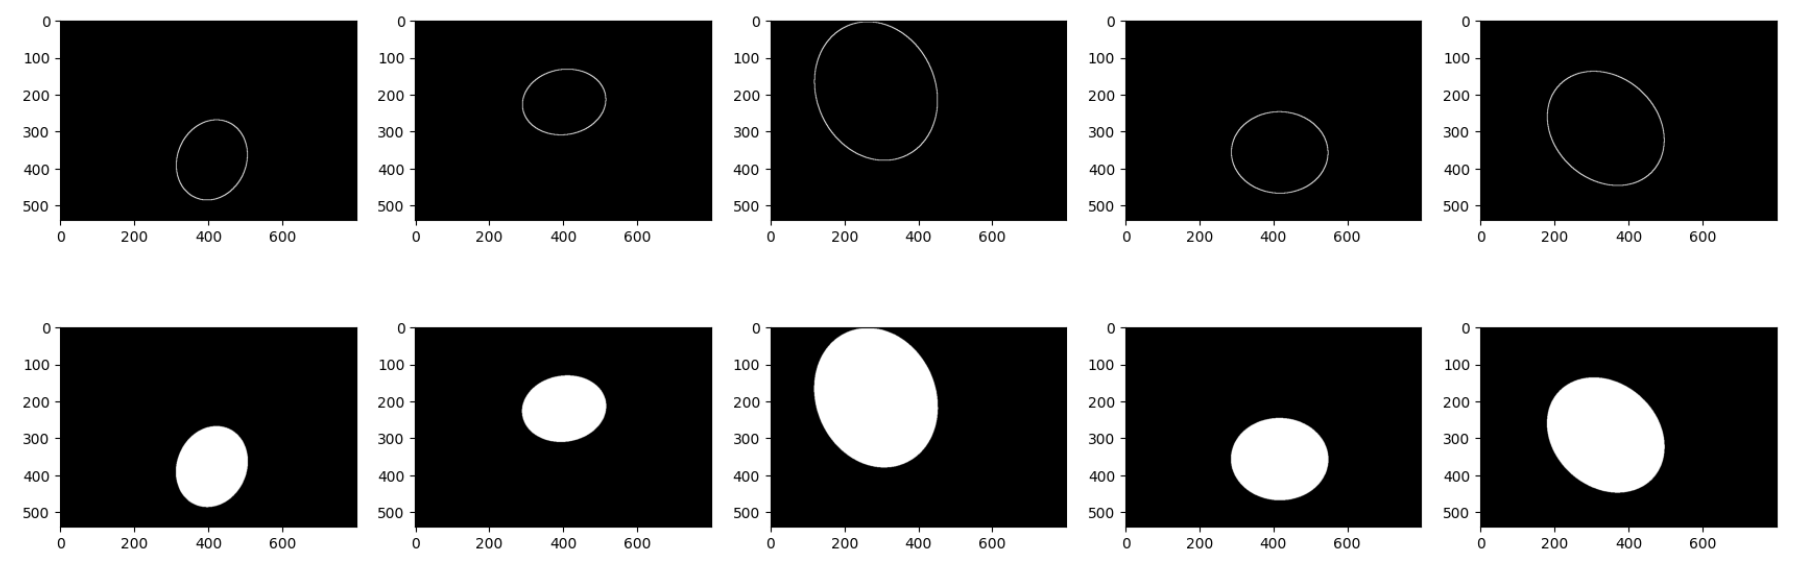
</div>

In [ ]:
# Check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(5):
  file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  #print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

Do not proceed until you get the right masks for the first five annotations.

In [ ]:
# Here we loop through training set and  take annotations one by one and REPLACE them with corresponding masks
for index in range(len(train_pixel_file)):
    file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

### Warning!!!
Do not run the above code again! The images you downloaded have been modified with the masks.

# Start from here!
# Libraries Import

In [ ]:
# Uncomment these if you have errors running the next cell

# !pip install scikit-image
# !pip install torch
# !pip install torchvision

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="0,1,2,3"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color #Scikit-Image
from PIL import Image # Pillow
import cv2

import os
import random

import torch # Will work on using PyTorch here later
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
print(torch.__version__)

# Create Datasets

In [ ]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

We will initialize the training and validation dataset with the following class

In [ ]:
class HC18(Dataset):
    def __init__(self, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # Split the dataset to train and validation using sklearn function train_test_split
        self.train_data, self.validation_data = train_test_split(self.pixel_file, 
                                                                 test_size = validation_set_size, 
                                                                 random_state = 5)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.validation_data)
    
    def __getitem__(self, index):
        if self.train:
            imx_name = os.path.join('training_set', 
                                  self.train_data.iloc[index, 0])
            imy_name = os.path.join('training_set',
                                  self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))
        else:
            imx_name = os.path.join('training_set', 
                                  self.validation_data.iloc[index, 0])
            imy_name = os.path.join('training_set',
                                  self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        imx = Image.open(imx_name)
        # Changing the image to greyscale, visit https://pillow.readthedocs.io/en/stable/reference/Image.html
        imy = Image.open(imy_name).convert('L')
        
        # We can try to not use these later, as of now, just follow what the author has
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)

          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        # We will use resize, tensorlize, and normalize in the following cell
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

Here, we will initialize the transform functions and create our training and validation dataset

In [ ]:
# Init transform functions
tx_X = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),  ################ no need to normalize the maskk
                           # transforms.Normalize((0.5,), (0.5,))
                          ])
train_data = HC18(train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18(train = False, transformX = tx_X, transformY = tx_Y )

In [ ]:
# Dataloaders

# num_workers = 2 result in error, we can come back to see why; change it to 0 temporarily
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 0)
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 0)

In [ ]:
# The following functions will return numpy array from the transformed tensors which were
# obtained from our train_loader. Plot them and see if they are intact
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy 
                                                # as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
    # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image 
                                                # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() 
    image = image.transpose(1,2,0) 
    # print(image.shape)
    image = image * np.array((1, 1, 1)) 
    image = image.clip(0, 1) 
    return image

### This is something your will get running the following code
<br>
<div>
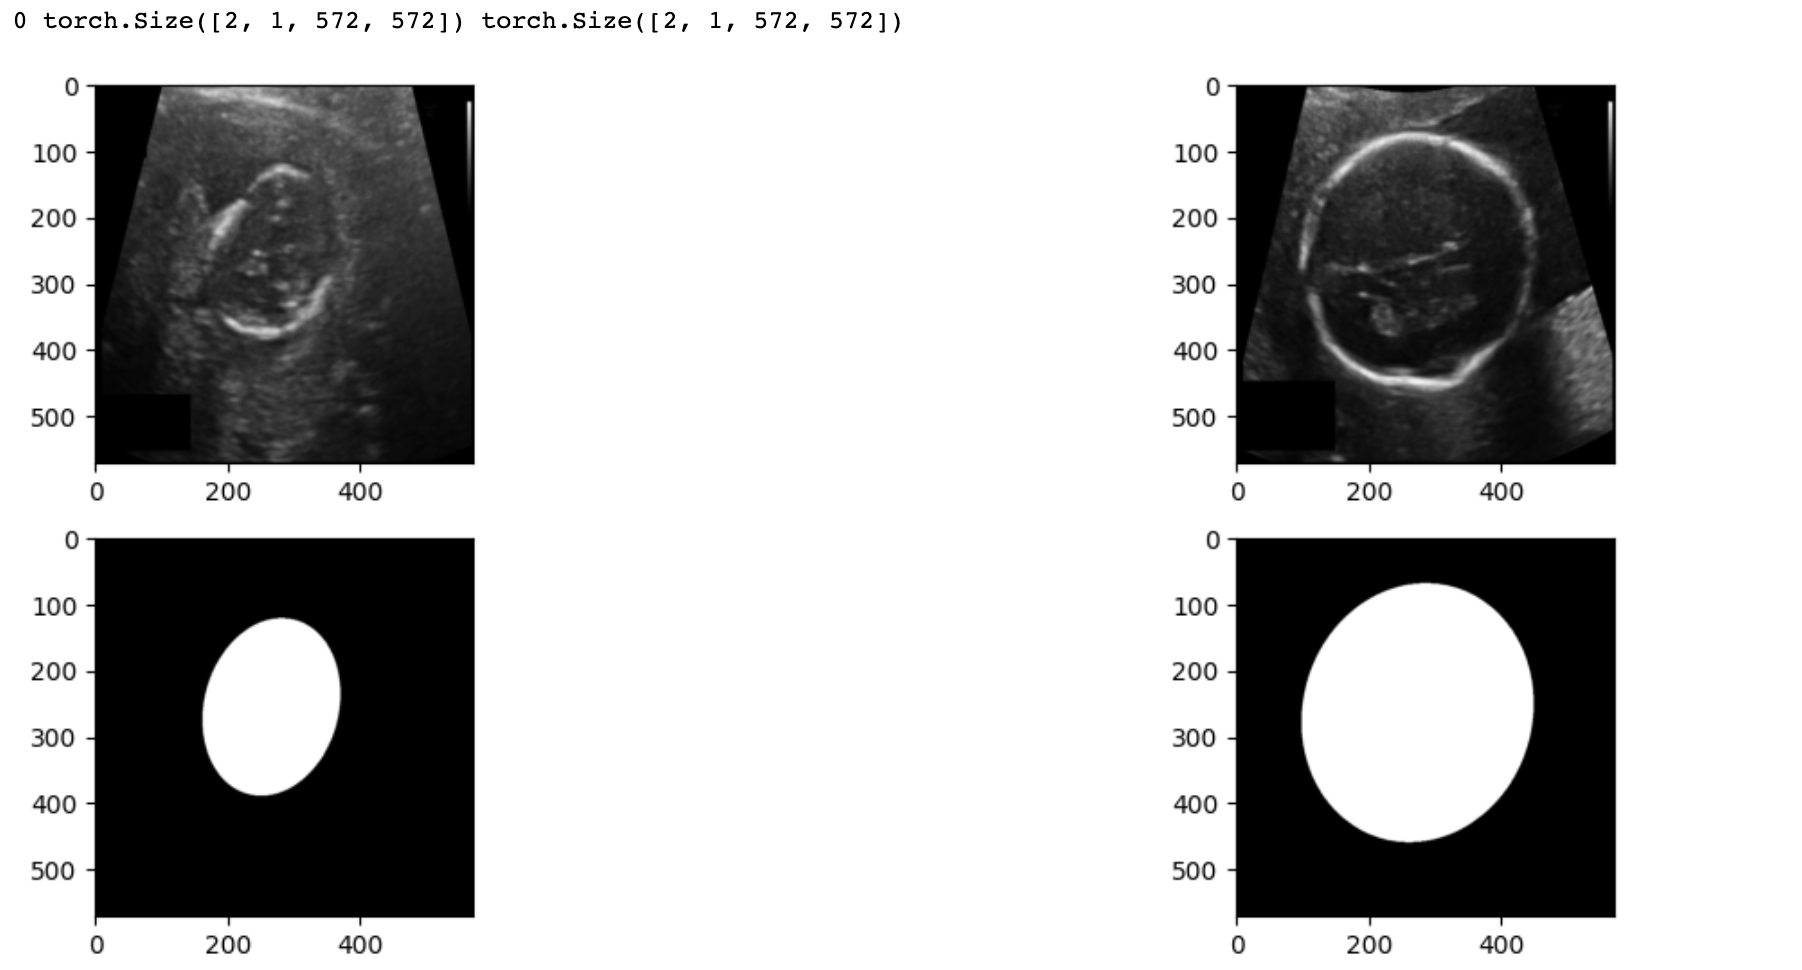
</div>

In [ ]:
## Here we loop through our train_loader and see the images
fig = plt.figure(figsize = (15,6))

for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

# Build the Model

The following class are the steps for building the UNet model

Building the UNet model

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2), 
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear: # Upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
        # x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        #x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

# Res-U-Net

In [ ]:
class res_conv(nn.Module):
    def __init__(self, in_ch, out_ch, down=True):
        super(res_conv, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            # nn.Dropout(0.5),
            nn.ReLU(inplace = True),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace = True),
            # nn.Dropout(0.5),
            )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = res_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            res_conv(in_ch, out_ch),
            )

    def forward(self,x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
        self.conv = res_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # self.conv = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1),
        #                          nn.Sigmoid())
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class ResUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(ResUNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
model = ResUNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

# Unet++

In [ ]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [ ]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)
    
class unetUp_origin(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp_origin, self).__init__()
        # self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        x1 = self.up(inputs0)
        # input is CHW
        for i in range(len(input)):
            try:
                x1 = torch.cat((x1,input[i]),1)
            except:
                x1 = torch.cat((F.pad(x1,(1,0,1,0)),input[i]),1)
        return self.conv(x1)

In [ ]:
class UNet_2Plus(nn.Module):
    def __init__(self, in_channels=1, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_2Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        # downsampling
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)


        # upsampling
        self.up_concat01 = unetUp_origin(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp_origin(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp_origin(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp_origin(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp_origin(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp_origin(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp_origin(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp_origin(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp_origin(filters[2], filters[1], self.is_deconv, 4)

        self.up_concat04 = unetUp_origin(filters[1], filters[0], self.is_deconv, 5)

        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)
        maxpool0 = self.maxpool0(X_00)
        X_10 = self.conv10(maxpool0)
        maxpool1 = self.maxpool1(X_10)
        X_20 = self.conv20(maxpool1)
        maxpool2 = self.maxpool2(X_20)
        X_30 = self.conv30(maxpool2)
        maxpool3 = self.maxpool3(X_30)
        X_40 = self.conv40(maxpool3)

        # column : 1
        X_01 = self.up_concat01(X_10, X_00)
        X_11 = self.up_concat11(X_20, X_10)
        X_21 = self.up_concat21(X_30, X_20)
        X_31 = self.up_concat31(X_40, X_30)
        # column : 2
        X_02 = self.up_concat02(X_11, X_00, X_01)
        X_12 = self.up_concat12(X_21, X_10, X_11)
        X_22 = self.up_concat22(X_31, X_20, X_21)
        # column : 3
        X_03 = self.up_concat03(X_12, X_00, X_01, X_02)
        X_13 = self.up_concat13(X_22, X_10, X_11, X_12)
        # column : 4
        X_04 = self.up_concat04(X_13, X_00, X_01, X_02, X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1 + final_2 + final_3 + final_4) / 4

        if self.is_ds:
            return F.sigmoid(final)
        else:
            return F.sigmoid(final_4)

In [ ]:
model = UNet_2Plus()
model.to('cuda')
print("Model Loaded to GPU")

In [ ]:
class UNet_3Plus(nn.Module):

    def __init__(self, in_channels=1, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')
    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, F.pad(h4_Cat_hd4,(1,0,1,0)), 
                       F.pad(hd5_UT_hd4, (2,0,2,0))), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))

        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3[:,:,:143,:143], F.pad(hd5_UT_hd3,(3,0,3,0))), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2[:,:,:286,:286], F.pad(hd5_UT_hd2,(6,0,6,0))), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1[:,:,:572,:572], F.pad(hd5_UT_hd1,(12,0,12,0))), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

In [ ]:
model = torch.nn.DataParallel(UNet_3Plus()).cuda()
print("Model Loaded to GPU")

# R2U-Net

In [ ]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1

In [ ]:
class R2U_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,F.pad(d5,(1,0,1,0))),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,F.pad(d4,(1,0,1,0))),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3)),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,F.pad(d2,(1,0,1,0))),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [ ]:
model = R2U_Net()
model = model.cuda()

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
!nvidia-smi

In [ ]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
    return 1 -(dice_index(y_predict, y_train))

In [ ]:
epochs = 20 

train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0  
    model.train()
    for ith_batch, sample_batched in enumerate(train_loader):
        X_train = sample_batched['image'].cuda()
        y_train = sample_batched['annotation'].to("cuda:0")
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        if ith_batch % 50 == 0:
            print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
        train_running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                X_val = sample_batched['image'].cuda()
                y_val = sample_batched['annotation'].to("cuda:0")
                y_out = model(X_val)
                out_val = (y_out + 0.5).int().float()
                val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
                validation_running_loss += val_loss.item()
            print("================================================================================")
            print("Epoch {} completed".format(e + 1))

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            print("Average train loss is {}: ".format(train_epoch_loss))
            print("Average validation loss is {}".format(validation_epoch_loss))
            print("================================================================================")
            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)

    torch.cuda.empty_cache()

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

In [ ]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

In [ ]:
class HC18_test(Dataset):
    def __init__(self, transformX = None):
        self.pixel_file = pd.read_csv('test_set_pixel_size.csv')
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join('test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [ ]:
test_data = HC18_test(transformX = tx_X)

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [ ]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [ ]:
def avg_dice_index(dataloader):
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            y_predict = (model(X_train) + 0.5).int().float()
            dice += dice_index(y_predict, y_train)
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)    #### Dice index of validation data

In [ ]:
avg_dice_index(train_loader)    #### Dice index of validation data